<a href="https://colab.research.google.com/github/tulsisahu9785-cpu/EDA-/blob/main/datascience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [42]:
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score


In [43]:
file_path=r'/content/historical_data.csv'
trader_df=pd.read_csv(file_path)
file_path=r'/content/fear_greed_index.csv'
sentiment_df=pd.read_csv(file_path)

In [44]:
sentiment_df.head(5)

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [45]:
trader_df.head(5)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [46]:
print(trader_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [47]:
print(sentiment_df.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [48]:
trader_df.columns = [c.strip() for c in trader_df.columns]
sentiment_df.columns = [c.strip() for c in sentiment_df.columns]


In [49]:
time_col = 'Timestamp IST' if 'Timestamp IST' in trader_df.columns else ('Timestamp' if 'Timestamp' in trader_df.columns else None)
if time_col is None:
    raise ValueError("No timestamp column found in trader_df (expected 'Timestamp IST' or 'Timestamp').")


In [50]:
trader_df['ts_parsed'] = pd.to_datetime(trader_df[time_col], errors='coerce', infer_datetime_format=True)
trader_df['Date'] = trader_df['ts_parsed'].dt.date


In [51]:
if 'date' in sentiment_df.columns:
    sentiment_df['Date'] = pd.to_datetime(sentiment_df['date'], errors='coerce').dt.date
elif 'timestamp' in sentiment_df.columns:
    sentiment_df['Date'] = pd.to_datetime(sentiment_df['timestamp'], errors='coerce').dt.date
else:
    raise ValueError("No date column found in sentiment_df file (expected 'date' or 'timestamp').")

if 'value' in sentiment_df.columns:
    sentiment_df['sentiment_df_value'] = pd.to_numeric(sentiment_df['value'], errors='coerce')
else:
    sentiment_df['sentiment_df_value'] = np.nan
    if 'classification' in sentiment_df.columns:
        sentiment_df['classification'] = sentiment_df['classification'].astype(str)
    else:
        sentiment_df['classification'] = np.nan




In [52]:
num_cols = ['Size Tokens','Size USD','Closed PnL','Execution Price','Start Position','Fee']
for col in num_cols:
    if col in trader_df.columns:
        trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')

if 'Side' in trader_df.columns:
    trader_df['Side'] = trader_df['Side'].astype(str).str.strip().str.lower()
if 'Direction' in trader_df.columns:
    trader_df['Direction'] = trader_df['Direction'].astype(str).str.strip().str.lower()

In [53]:
trader_df['profit_flag'] = trader_df['Closed PnL'] > 0

In [54]:
leverage_proxy_available = False
if 'Start Position' in trader_df.columns and trader_df['Start Position'].notna().sum() > 0:
    trader_df['start_pos_abs'] = trader_df['Start Position'].abs().replace({0: np.nan})
    trader_df['exposure_ratio_proxy'] = trader_df['Size USD'] / trader_df['start_pos_abs']
    if trader_df['exposure_ratio_proxy'].notna().sum() > 0:
        leverage_proxy_available = True


In [55]:
agg_dict = {
    'Size USD': ['sum','mean','median'],
    'Size Tokens': ['sum','mean'],
    'Closed PnL': ['sum','mean','median'],
    'Execution Price': ['mean'],
    'Fee': ['sum','mean'],
    'Trade ID': ['count'],
    'Account': ['nunique'],
    'profit_flag': ['sum']
}
daily = trader_df.groupby('Date').agg(agg_dict)
daily.columns = ['_'.join([str(c) for c in col]).strip() for col in daily.columns.values]
daily = daily.reset_index().rename(columns={
    'Trade ID_count':'trades_count',
    'Account_nunique':'unique_accounts',
    'profit_flag_sum':'profitable_trades'
})
daily['win_rate'] = daily['profitable_trades'] / daily['trades_count']
daily['avg_trade_size_usd'] = daily['Size USD_mean']
daily['total_volume_usd'] = daily['Size USD_sum']
daily['net_closed_pnl'] = daily['Closed PnL_sum']

if leverage_proxy_available:
    expo = trader_df.groupby('Date')['exposure_ratio_proxy'].agg(['mean','median','max']).reset_index().rename(
        columns={'mean':'exposure_ratio_mean','median':'exposure_ratio_median','max':'exposure_ratio_max'})
    daily = daily.merge(expo, on='Date', how='left')

In [56]:
sent_daily = sentiment_df[['Date','sentiment_df_value','classification']].drop_duplicates(subset=['Date'])
daily = daily.merge(sent_daily, on='Date', how='left')
daily['classification'] = daily['classification'].fillna('Unknown')

In [57]:
# Exploratory visuals

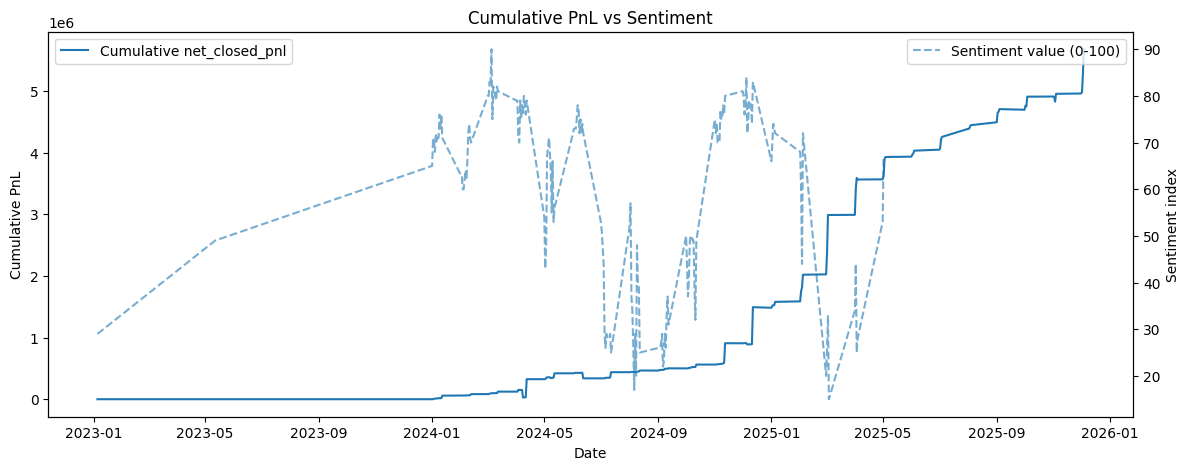

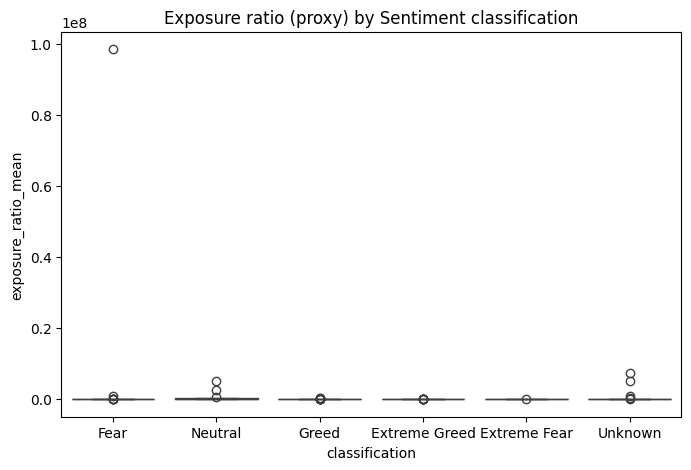

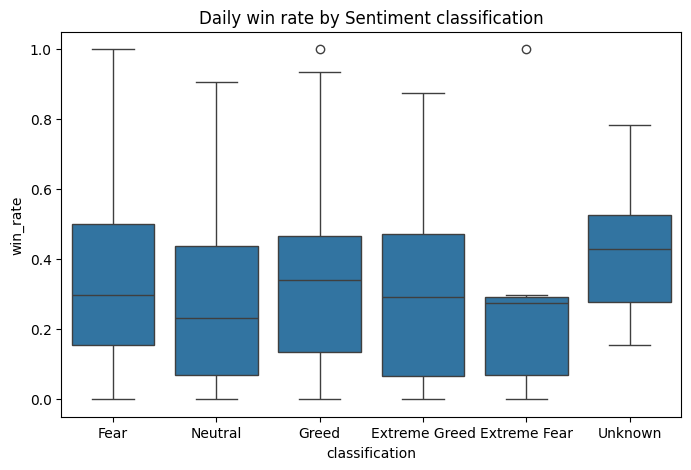

In [58]:
import matplotlib.dates as mdates
plt.figure(figsize=(14,5))
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(pd.to_datetime(daily['Date']), daily['net_closed_pnl'].cumsum(), label='Cumulative net_closed_pnl')
ax2.plot(pd.to_datetime(daily['Date']), daily['sentiment_df_value'], alpha=0.6, linestyle='--', label='Sentiment value (0-100)')
ax.set_xlabel('Date'); ax.set_ylabel('Cumulative PnL'); ax2.set_ylabel('Sentiment index')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.title('Cumulative PnL vs Sentiment')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.show()

if leverage_proxy_available:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=daily.dropna(subset=['exposure_ratio_mean']), x='classification', y='exposure_ratio_mean')
    plt.title('Exposure ratio (proxy) by Sentiment classification')
    plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=daily, x='classification', y='win_rate')
plt.title('Daily win rate by Sentiment classification')
plt.show()

In [59]:
# Statistical tests Fear vs Greed

In [60]:
metrics = ['net_closed_pnl','total_volume_usd','avg_trade_size_usd','win_rate']
results = {}
for m in metrics:
    if m in daily.columns:
        fear_vals = daily[daily['classification'].str.lower()=='fear'][m].dropna()
        greed_vals = daily[daily['classification'].str.lower()=='greed'][m].dropna()
        if len(fear_vals)>5 and len(greed_vals)>5:
            tstat, p = ttest_ind(fear_vals, greed_vals, equal_var=False, nan_policy='omit')
            ustat, up = mannwhitneyu(fear_vals, greed_vals, alternative='two-sided')
            results[m] = {'t_pvalue':p, 'u_pvalue':up, 'fear_mean':fear_vals.mean(), 'greed_mean':greed_vals.mean()}
results


{'net_closed_pnl': {'t_pvalue': np.float64(0.10585133025087051),
  'u_pvalue': np.float64(0.4787979897718182),
  'fear_mean': np.float64(48087.17790956756),
  'greed_mean': np.float64(10886.295225642856)},
 'total_volume_usd': {'t_pvalue': np.float64(0.18768676862624914),
  'u_pvalue': np.float64(0.4534898126976029),
  'fear_mean': np.float64(2153361.920540541),
  'greed_mean': np.float64(1018675.2810714286)},
 'avg_trade_size_usd': {'t_pvalue': np.float64(0.7780608884480644),
  'u_pvalue': np.float64(0.9655650318776328),
  'fear_mean': np.float64(6014.62391849731),
  'greed_mean': np.float64(6352.086534536766)},
 'win_rate': {'t_pvalue': np.float64(0.8144653801768079),
  'u_pvalue': np.float64(0.7203004622021586),
  'fear_mean': np.float64(0.3480706649314948),
  'greed_mean': np.float64(0.36241481527428093)}}

In [61]:
# Rolling correlations & lagged cross-correlation








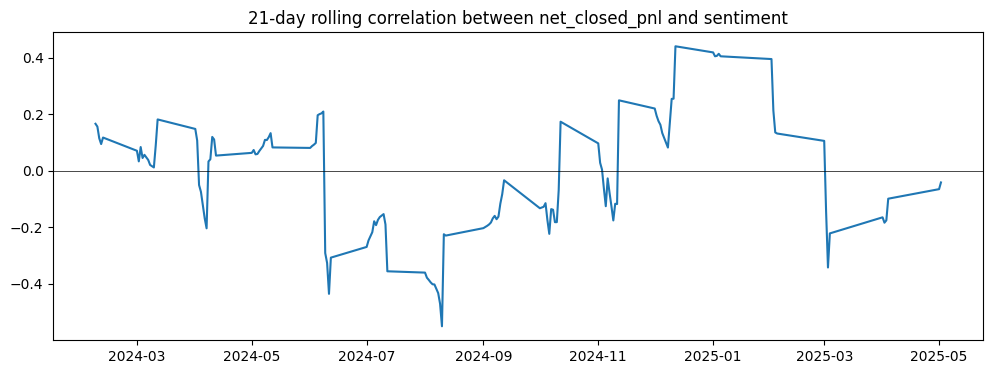

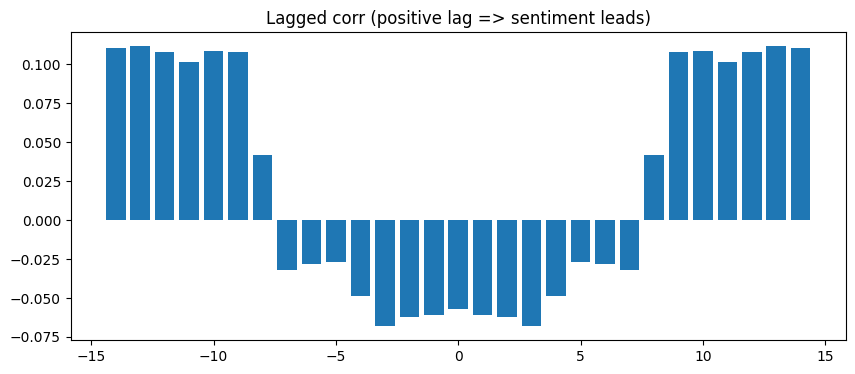

In [62]:
daily_sorted = daily.sort_values('Date').dropna(subset=['sentiment_df_value'])
for w in [7,21,60]:
    colname = f'corr_{w}d_pnl_sent'
    daily_sorted[colname] = daily_sorted['net_closed_pnl'].rolling(window=w).corr(daily_sorted['sentiment_df_value'])

plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(daily_sorted['Date']), daily_sorted['corr_21d_pnl_sent'])
plt.title('21-day rolling correlation between net_closed_pnl and sentiment')
plt.axhline(0,color='k',linewidth=0.5)
plt.show()

def lagged_corr(sx, sy, maxlag=14):
    res = {}
    for lag in range(-maxlag, maxlag+1):
        if lag < 0: a = sx[:lag]; b = sy[-lag:]
        elif lag > 0: a = sx[lag:]; b = sy[:-lag]
        else: a = sx; b = sy
        res[lag] = a.corr(b)
    return res

if daily_sorted['sentiment_df_value'].notna().sum() > 0:
    corr_dict = lagged_corr(daily_sorted['sentiment_df_value'].reset_index(drop=True),
                            daily_sorted['net_closed_pnl'].reset_index(drop=True), maxlag=14)
    lags = list(corr_dict.keys()); vals = list(corr_dict.values())
    plt.figure(figsize=(10,4)); plt.bar(lags, vals); plt.title('Lagged corr (positive lag => sentiment leads)'); plt.show()

In [63]:
# Granger causality


In [64]:
gc_df = daily_sorted[['net_closed_pnl','sentiment_df_value']].dropna()
if len(gc_df) > 30:
    try:
        grangercausalitytests(gc_df[['net_closed_pnl','sentiment_df_value']], maxlag=7, verbose=False)
        grangercausalitytests(gc_df[['sentiment_df_value','net_closed_pnl']], maxlag=7, verbose=False)
        print("Granger causality tests run (check verbose output above).")
    except Exception as e:
        print("Granger causality failed:", e)

Granger causality tests run (check verbose output above).


In [65]:
# Predictive model example








In [66]:
df = daily_sorted.copy()
df['target_next_pos'] = (df['net_closed_pnl'].shift(-1) > 0).astype(int)
features = ['sentiment_df_value','total_volume_usd','avg_trade_size_usd','win_rate']
df_model = df.dropna(subset=features + ['target_next_pos'])
if len(df_model) > 50:
    X = df_model[features]; y = df_model['target_next_pos']
    tscv = TimeSeriesSplit(n_splits=5)
    aucs = []
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    for train_idx, test_idx in tscv.split(X):
        clf.fit(X.iloc[train_idx], y.iloc[train_idx])
        p = clf.predict_proba(X.iloc[test_idx])[:,1]
        aucs.append(roc_auc_score(y.iloc[test_idx], p))
    print("Time-series CV ROC AUCs:", aucs, "mean:", np.mean(aucs))
if daily_sorted['sentiment_df_value'].notna().sum() > 0:
    q_low = daily_sorted['sentiment_df_value'].quantile(0.10)
    q_high = daily_sorted['sentiment_df_value'].quantile(0.90)
    low_days = daily_sorted[daily_sorted['sentiment_df_value'] <= q_low]['Date']
    high_days = daily_sorted[daily_sorted['sentiment_df_value'] >= q_high]['Date']

    def event_window_avg(dates, window=7):
        rows = []
        for d in dates:
            center_idx = daily_sorted.index[daily_sorted['Date'] == d].tolist()
            if not center_idx: continue
            i = center_idx[0]
            start = max(0, i-window); end = min(len(daily_sorted)-1, i+window)
            window_df = daily_sorted.iloc[start:end+1]
            rows.append(window_df['net_closed_pnl'].values)
        return rows

Time-series CV ROC AUCs: [np.float64(0.4248366013071896), np.float64(0.4548611111111111), np.float64(0.31875), np.float64(0.6284722222222221), np.float64(0.6166666666666667)] mean: 0.48871732026143794


In [67]:
# Save aggregated results

In [68]:
# Build account-level features: avg pnl per trade, avg size, win_rate, trade_count
acct_feat = trader_df.groupby('Account').agg({
    'Closed PnL': ['mean','sum'],
    'Size USD': ['mean','sum'],
    'Trade ID': 'count',
    'profit_flag': 'mean'
}).reset_index()

acct_feat.columns = ['Account','pnl_mean','pnl_sum','size_mean','size_sum','trade_count','win_rate']

# filter accounts with > X trades
acct_feat = acct_feat[acct_feat['trade_count'] >= 5]

if len(acct_feat) >= 3:
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans

    X = acct_feat[['pnl_mean','size_mean','win_rate']].fillna(0)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    k = 3
    km = KMeans(n_clusters=k, random_state=42)
    acct_feat['cluster'] = km.fit_predict(X_scaled)

    print("Account clusters size:", acct_feat['cluster'].value_counts())
else:
    acct_feat['cluster'] = -1   # dummy cluster if not enough accounts




Account clusters size: cluster
1    21
0     6
2     5
Name: count, dtype: int64


In [69]:
daily.to_csv("daily_aggregates_sentiment.csv", index=False)
acct_feat.to_csv("account_features_clusters.csv", index=False)

print("Done. Saved daily_aggregates_sentiment.csv and account_features_clusters.csv")

Done. Saved daily_aggregates_sentiment.csv and account_features_clusters.csv
